توجه: فقط قسمت های خواسته شده را تکمیل کنید و همراه فایل خود مدل آموزش دیده را ارسال کنید.

هدف این تمرین :


1.   ساخت دیتاست مورد نیاز و نوشتن کلاس دیتاست
2.   Augmentation
3.   نوشتن مدل دسته بندی 3 کلاسه با استفاده از چند کلاس پایتون



In [1]:
%%capture

!wget http://data.csail.mit.edu/places/ADEchallenge/release_test.zip
!wget http://data.csail.mit.edu/places/ADEchallenge/ADEChallengeData2016.zip
!unzip ADEChallengeData2016.zip
!unzip release_test.zip
!pip install mmengine

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import glob

from cv2 import imread as IM
from os import path
import pathlib

from torch.utils.data import Dataset
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import random
from torch.utils.data import random_split

from random import randint
import matplotlib.pyplot as plt

## Data Generation

در این قسمت برای ساخت دیتاست مورد نیاز باید از هر تصویر دانلود شده ،2 تصویر یکی بدون تغییر و دیگری تغییر یافته به سایز 224 در 224 تولید کنید .به این منظور ابتداتابع های 1تا 6 را کامل کرده و سپس از تابع های 1تا3 برای ساخت تصویر تغییر یافته استفاده کنید.توجه داشته باشید که در تصاویر تولیدی تعدادی فقط یک تغییر و تعدادی دو و سه تغییر را باید داشته باشند،همچنین در تصاویر تولید شده نباید قسمت مشکی ناشی از چرخش وجود داشته باشد




برای ساخت دیتاست 3 تابع جدید برای اعمال ترکیبی جابجایی چرخش و اسکیل تعریف شده است. هریک از توابع با کامنت توضیح داده شده است.

In [3]:
# function 1
def displacement(img):
    """
    Apply displacement to an input image.

    Args:
    - image: numPy array representing the input image.

    Returns:
    - displaced image as a NumPy array with shape [224, 224, 3].
    """
    height, width, _ = img.shape
    x_center = random.randint(112, width-112)
    y_center = random.randint(112, height-112)

    left = x_center - 112
    right = x_center + 112
    bottom = y_center - 112
    top = y_center + 112

    img = img[bottom:top, left:right]

    return img

# function 2
def rotation(img):
    """
    Rotate an input image.

    Parameters:
    - img: numPy array representing the input image.

    Returns:
    - rotated image as a NumPy array with shape[224, 224, 3].
    """
    # Randomly choose one of the angle ranges
    selected_range = random.choice([(-30, -5), (5, 30)])

    # Generate a random integer in the selected range
    angle = random.randint(*selected_range)

    # Get the center of the image
    center = (img.shape[1] // 2, img.shape[0] // 2)

    # Define the rotation matrix
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)

    # Apply the rotation using warpAffine
    img_rotate = cv2.warpAffine(img, rotation_matrix, (img.shape[1], img.shape[0]))

    height, width, _ = img_rotate.shape
    left = (width // 2) - 112
    right = (width // 2) + 112
    bottom = (height // 2) - 112
    top = (height // 2) + 112
    img = img_rotate[bottom:top, left:right]

    return img


# function 3
def scaling(img):
    ## To Do
    """
    Scale the input image by a random factor.

    Args:
    - image: numPy array representing the input image.

    Returns:
    - scaled image as a NumPy array with shape [224, 224, 3].
    """
    height, width, _ = img.shape
    random_numbers = np.arange(round(224/(min(height, width)), 1) + 0.1, 2.1, 0.1)
    random_idx = int(np.ceil(random.uniform(0, len(random_numbers)-1)))
    scale_factor = random_numbers[random_idx]
    # resize the image by a random scale factor
    img = cv2.resize(img, None, fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_AREA)
    height, width, _ = img.shape
    left = (width // 2) - 112
    right = (width // 2) + 112
    bottom = (height // 2) - 112
    top = (height // 2) + 112
    img = img[bottom:top, left:right]

    return img



# function 4
def Brightness(img):  ## for augmentation
    """
    Change the brightness of an image by adding a random offset.

    Args:
    - image: numPy array representing the input image.

    Returns:
    - brightness changed image as a NumPy array with shape [224, 224, 3].
    """
    
    img_float = img.astype(np.float64)
    brightness_value = random.randint(-40, 40)
    img_float = img_float + brightness_value

    # Clip values to stay in range [0, 255] and convert back to uint8
    img = np.clip(img_float, 0, 255).astype(np.uint8)

    return img



# function 5
def bluring(img):# for augmentation
    '''
    Bluring the input image by a random intensity.

    Args:
    - image: NumPy array representing the input image.

    Returns:
    - blurred image as a NumPy array with shape [224, 224, 3].    
    '''
    blur_intensity = random.choice([1, 3, 5, 7, 9])

    # Apply Gaussian Blur
    img = cv2.GaussianBlur(img, (blur_intensity, blur_intensity), 0)

    # Write/save the blurred image
    #cv2.imwrite(output_image_path, blurred_image)
    return img

# function 6
def gaussian_noise(img):#for augmentation
    """
    This function adds Gaussian noise with N(0, 1) distribution to the input image.

    Args:
    - image: numPy array representing the input image.

    Returns:
    - noisy image as a NumPy array with shape [224, 224, 3].
    """
    mean = 0
    sigma = 1
    gauss = np.random.normal(mean, sigma, img.shape).reshape(img.shape)
    # Add the Gaussian noise to the image
    img = cv2.add(img, gauss.astype('uint8'))

    #cv2.imwrite(output_image_path, img)
    return img

#the next three functions are combinations of firt three functions
def displacement_rotation(img):
    '''
    Apply rotation and displacement to the input image by a random factor.
    First the center of rotation is moved using random numbers and then rotation is applied

    Args:
    - image: NumPy array representing the input image.

    Returns:
    - changed image as a NumPy array with shape [224, 224, 3].
    '''
    height, width, _ = img.shape
    x_center = random.randint(112, width-112)
    y_center = random.randint(112, height-112)

    # Randomly choose one of the angle ranges
    selected_range = random.choice([(-20, -5), (5, 20)])

    # Generate a random integer in the selected range
    angle = random.randint(*selected_range)

    # Get the center of the image
    center = (x_center, y_center)

    # Define the rotation matrix
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)

    # Apply the rotation using warpAffine
    img_rotate = cv2.warpAffine(img, rotation_matrix, (img.shape[1], img.shape[0]))

    left = (width // 2) - 112
    right = (width // 2) + 112
    bottom = (height // 2) - 112
    top = (height // 2) + 112
    img = img_rotate[bottom:top, left:right]

    return img

def scaling_rotation(img):
    '''
    Apply rotation and scaling to the input image by a random factor.
    First scale image and then rotation is applied

    Args:
    - image: NumPy array representing the input image.

    Returns:
    - changed image as a NumPy array with shape [224, 224, 3].
    '''
    height, width, _ = img.shape

    random_numbers = np.arange(round(224/(min(height, width)), 1) + 0.1, 2.1, 0.1)
    random_idx = int(np.ceil(random.uniform(0, len(random_numbers)-1)))
    scale_factor = random_numbers[random_idx]

    img = cv2.resize(img, None, fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_AREA)

    height, width, _ = img.shape

    # Randomly choose one of the angle ranges
    selected_range = random.choice([(-10, -1), (1, 10)])

    # Generate a random integer in the selected range
    angle = random.randint(*selected_range)

    # Get the center of the image
    center = (width // 2, height // 2)

    # Define the rotation matrix
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)

    # Apply the rotation using warpAffine
    img_rotate = cv2.warpAffine(img, rotation_matrix, (img.shape[1], img.shape[0]))

    left = (width // 2) - 112
    right = (width // 2) + 112
    bottom = (height // 2) - 112
    top = (height // 2) + 112
    img = img_rotate[bottom:top, left:right]

    return img

def scaling_displacement(img):
    '''
    Apply scaling and displacement to the input image by a random factor.
    First scale image and then displacement is applied

    Args:
    - image: NumPy array representing the input image.

    Returns:
    - changed image as a NumPy array with shape [224, 224, 3].
    '''
    height, width, _ = img.shape
    random_numbers = np.arange(round(224/(min(height, width)), 1) + 0.1, 3, 0.1)
    random_idx = int(np.ceil(random.uniform(0, len(random_numbers)-1)))
    scale_factor = random_numbers[random_idx]

    img = cv2.resize(img, None, fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_AREA)

    height, width, _ = img.shape

    x_center = random.randint(112, width-112)
    y_center = random.randint(112, height-112)

    left = x_center - 112
    right = x_center + 112
    bottom = y_center - 112
    top = y_center + 112

    img = img[bottom:top, left:right]

    return img




In [4]:
class CustomDataset(Dataset):
    
    
    def __init__(self, dir, transform=None):
    '''
    Constructor function
    Args:
    - dir: direction of images
    - transform: transforms that should be applied to dataset
    '''
      ## To Do
      super().__init__()
      self.paths = list(pathlib.Path(dir).glob("*.jpg"))
      self.transform = transform
      #this threshold will use for rotation probability of image
      self._thresholds = [250, 650]

    def _crop_image(self, img):
    '''
    This function crops a 224x224 section from the center of the image.
    Args:
    - img: input image as numpy array
    Returns:
    - cropped image
    '''
        height, width, _ = img.shape
        left = (width // 2) - 112
        right = (width // 2) + 112
        bottom = (height // 2) - 112
        top = (height // 2) + 112
        img = img[bottom:top, left:right]
        return img

    def __getitem__(self,idx):
        '''
        Args:
         - idx: index of image
        Returns:
         - two images. cropped original image and translated image
        '''
        ## To Do
        img = IM(str(self.paths[idx]))
        
        #convert image to RGB in order to plt.imshow show them properly
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        #with probability of 0.5 images are augmented
        augment_prob = torch.bernoulli(torch.tensor(0.5))
        if (augment_prob):
            augment_type = random.choice([1, 2, 3])
            if augment_type == 1:
                img = Brightness(img)
            elif augment_type == 2:
                img = bluring(img)
            else:
                img = gaussian_noise(img)

        #images with height or width less than 224 should be resized to 224
        #for the small images the probability of applying rotation is fewer than large images 
        #because rotation of small image produces black pixels in rotated image
        #and to balance numbers of rotated images I put the prob of rotation for image with at least height or width equals to 650, one.
        #650 is specified in self._threshold
        height, width, _ = img.shape
        
        #rotation probability
        rotation_prob = np.interp(min(height, width), self._thresholds, [0, 1])
        if height<224:
            img = cv2.resize(img, (width, 224))
            height = 224
        if width < 224:
            img = cv2.resize(img, (224, height))
        img_1 = self._crop_image(img)

        #labels = [scaling, rotation, displacement]
        labels = [1, 1, 1]
        probs = [0.5, rotation_prob, 0.5]
        while(labels == [1, 1, 1]):
            labels = [random.random(), random.random(), random.random()]

            for i in range(3):
                if labels[i] < probs[i]:
                    labels[i] = 1
                else:
                    labels[i] = 0

        if labels == [0,0,0]:
            img_2 = img_1
        elif labels == [0,0,1]:
            img_2 = displacement(img)
        elif labels == [0,1,0]:
            img_2 = rotation(img)
        elif labels == [1,0,0]:
            img_2 = scaling(img)
        elif labels == [0,1,1]:
            img_2 = displacement_rotation(img)
        elif labels == [1,0,1]:
            img_2 = scaling_displacement(img)
        elif labels == [1,1,0]:
            img_2 = scaling_rotation(img)

        if self.transform:
            return self.transform(img_1), self.transform(img_2), torch.tensor(np.array(labels), dtype=torch.float)
        else:
            return torch.tensor(img_1, dtype=torch.float), torch.tensor(img_2, dtype=torch.float), torch.tensor(np.array(labels), dtype=torch.float)


    def __len__(self):
        ## To Do
        return len(self.paths)


In [5]:
train_transforms = transforms.ToTensor()
val_transforms = transforms.ToTensor()
test_transforms = transforms.ToTensor()

In [6]:
dataset_train = CustomDataset(dir="/kaggle/working/ADEChallengeData2016/images/training", transform=train_transforms)
dataset_val = CustomDataset(dir="/kaggle/working/ADEChallengeData2016/images/validation", transform=val_transforms)
dataset_test = CustomDataset(dir="/kaggle/working/release_test/testing", transform=test_transforms)


train_loader = DataLoader(dataset = dataset_train,
                          batch_size=32,
                          shuffle=True)
test_loader= DataLoader(dataset= dataset_test,
                        batch_size=32,
                        shuffle=False)
val_loader = DataLoader(dataset=dataset_val,
                        batch_size=32,
                        shuffle=False)


8 train image pairs


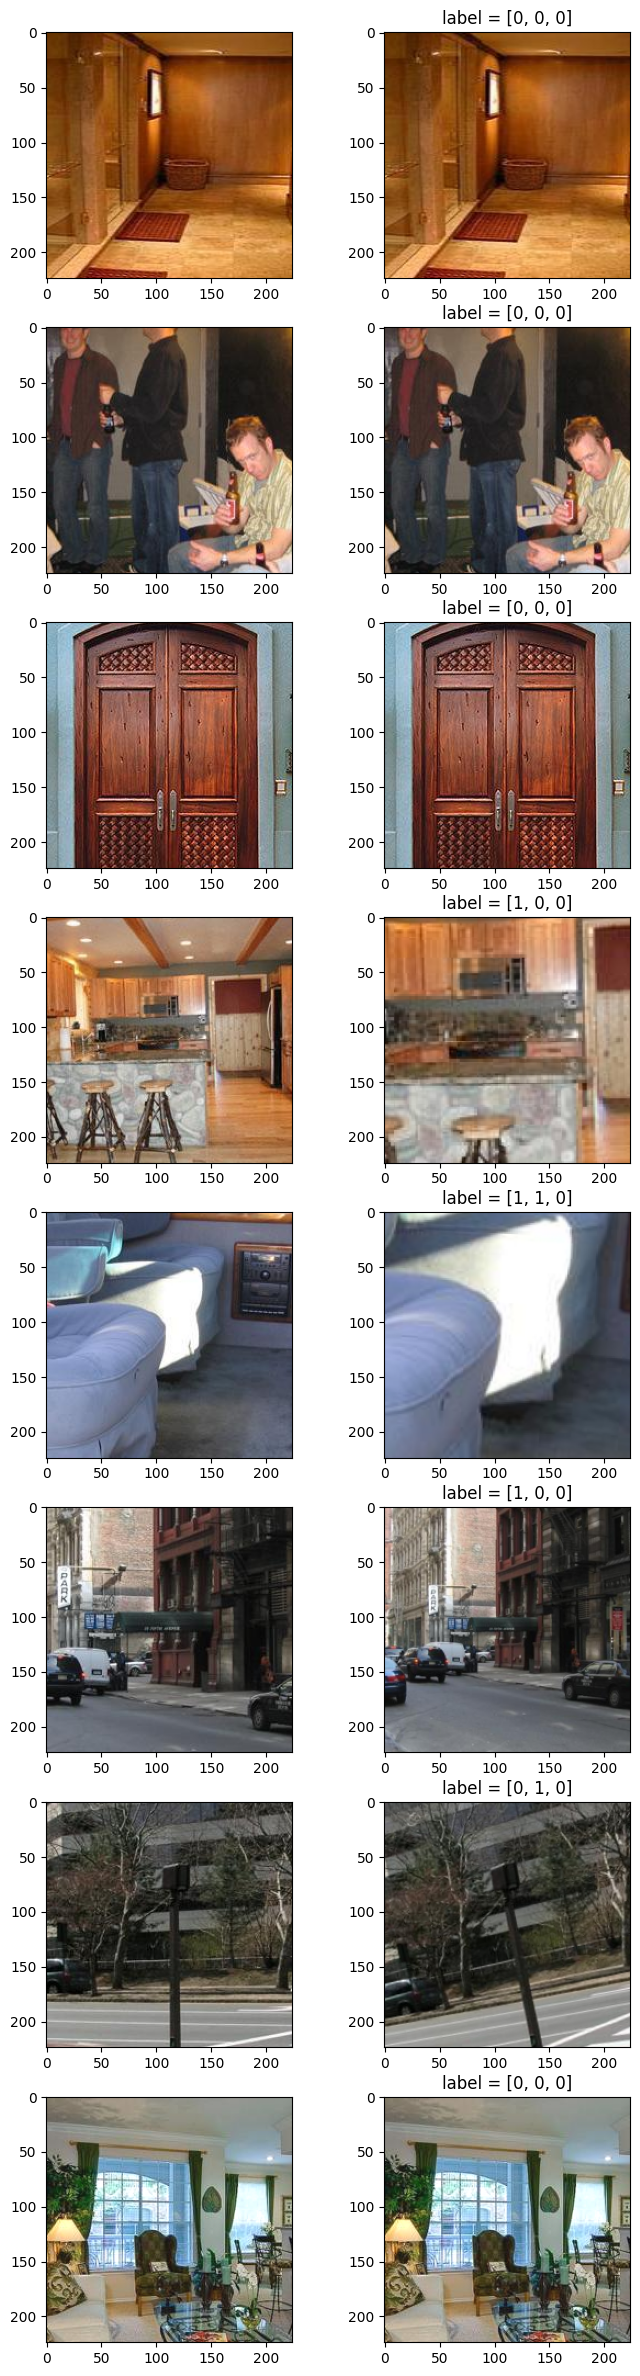

8 test image paris


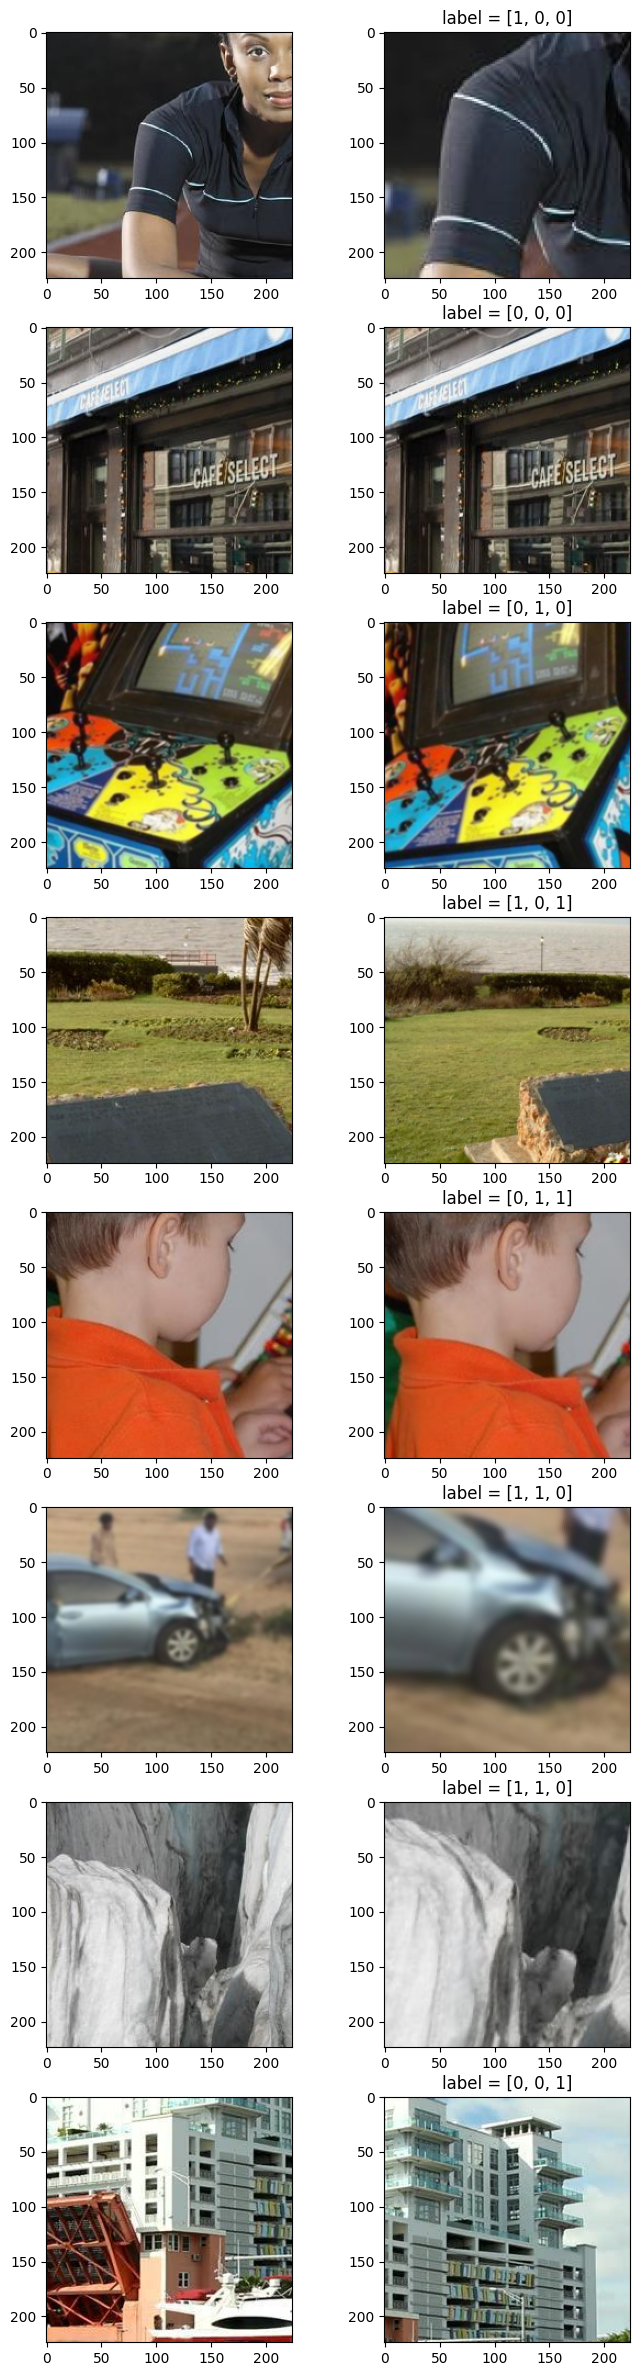

In [7]:
## To Do  : show 8 images from train_loader & 8 images from test_loader

#label = [scaling, rotation, displacement]
img1_train_batch, img2_train_batch, label_train_batch = next(iter(train_loader))
img1_test_batch, img2_test_batch, label_test_batch = next(iter(test_loader)) 
      
print("8 train image pairs")
plt.figure(figsize=(8, 30))
for i in range(8):

    img1 = img1_train_batch[i] 
    img2 = img2_train_batch[i] 
    plt.subplot(8, 2, 2*i+1)
    plt.imshow(img1.permute(1,2,0))
    plt.subplot(8, 2, 2*i+2)
    plt.imshow(img2.permute(1,2,0))
    l = [int(item) for item in list(label_train_batch)[i]]
    title = f"label = {l}"
    plt.title(title)

plt.show()

print("8 test image paris")
plt.figure(figsize=(8, 30))
for i in range(8):

    img1 = img1_train_batch[i] * 255
    img2 = img2_train_batch[i] * 255
    plt.subplot(8, 2, 2*i+1)
    plt.imshow(img1_test_batch[i].permute(1,2,0))
    plt.subplot(8, 2, 2*i+2)
    plt.imshow(img2_test_batch[i].permute(1,2,0))
    l = [int(item) for item in list(label_test_batch)[i]]
    title = f"label = {l}"
    plt.title(title)

##Model

در این قسمت میخواهیم یک مدل 3 کلاسه  مطبق شکل زیرکه شامل قسمت های زیر میشود را آموزش دهیم.

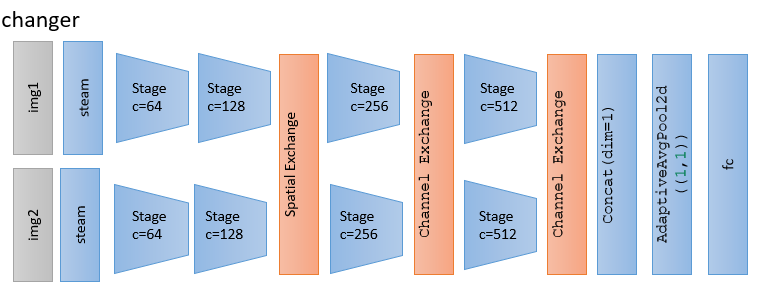

دو کلاس



1.   SpatialExchange
2.   ChannelExchange


 .مطابق شکل زیر ویژگی های دو تصویر را با هم عوض میکنند.


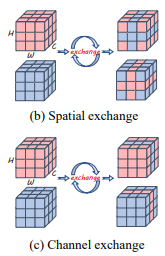

In [8]:
## dont change this block

from mmengine.model import BaseModule
class ChannelExchange(BaseModule):
    """
    channel exchange
    Args:
        p (float, optional): p of the features will be exchanged.
            Defaults to 1/2.
    """
    def __init__(self, p=1/2):
        super().__init__()
        assert p >= 0 and p <= 1
        self.p = int(1/p)

    def forward(self, x1, x2):
        N, c, h, w = x1.shape

        exchange_map = torch.arange(c) % self.p == 0
        exchange_mask = exchange_map.unsqueeze(0).expand((N, -1))

        out_x1, out_x2 = torch.zeros_like(x1), torch.zeros_like(x2)
        out_x1[~exchange_mask, ...] = x1[~exchange_mask, ...]
        out_x2[~exchange_mask, ...] = x2[~exchange_mask, ...]
        out_x1[exchange_mask, ...] = x2[exchange_mask, ...]
        out_x2[exchange_mask, ...] = x1[exchange_mask, ...]

        return out_x1, out_x2



class SpatialExchange(BaseModule):
    """
    spatial exchange
    Args:
        p (float, optional): p of the features will be exchanged.
            Defaults to 1/2.
    """
    def __init__(self, p=1/2):
        super().__init__()
        assert p >= 0 and p <= 1
        self.p = int(1/p)

    def forward(self, x1, x2):
        N, c, h, w = x1.shape
        exchange_mask = torch.arange(w) % self.p == 0

        out_x1, out_x2 = torch.zeros_like(x1), torch.zeros_like(x2)
        out_x1[..., ~exchange_mask] = x1[..., ~exchange_mask]
        out_x2[..., ~exchange_mask] = x2[..., ~exchange_mask]
        out_x1[..., exchange_mask] = x2[..., exchange_mask]
        out_x2[..., exchange_mask] = x1[..., exchange_mask]

        return out_x1, out_x2

شبکه ی زیر را پیاده کنید  

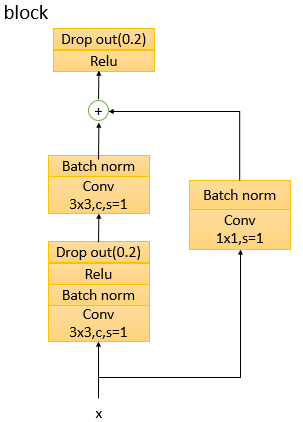

سوال تئوری1:
1.  مقادیر زیر را برای لایه های کانولوشن چه قدر در نظر گرفته اید؟
 channel out size (conv(1*1))
 padding(conv)
2.  دلیل استفاده از کانولوشن 1در1 چیست؟





1-مقدار چنل خروجی کانولوشن 1در1 همان 

In [9]:
##To Do
class block(nn.Module):
  def __init__(self,in_channel, c):
    super(block,self).__init__()
    self.sub_block1 = nn.Sequential(
        nn.Conv2d(in_channels=in_channel, out_channels=c, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(num_features=c),
        nn.ReLU(),
        nn.Dropout(0.2)
    )
    self.sub_block2 = nn.Sequential(
        nn.Conv2d(in_channels=c, out_channels=c, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(num_features=c)
    )
    self.sub_block3 = nn.Sequential(
        nn.Conv2d(in_channels=in_channel, out_channels=c, kernel_size=1, stride=1, padding=0),
        nn.BatchNorm2d(num_features=c)
    )
    self.sub_block4 = nn.Sequential(
        nn.ReLU(),
        nn.Dropout(0.2)
    )


  def forward(self,x):
    out = self.sub_block2(self.sub_block1(x)) + self.sub_block3(x)
    out = self.sub_block4(out)
    return out



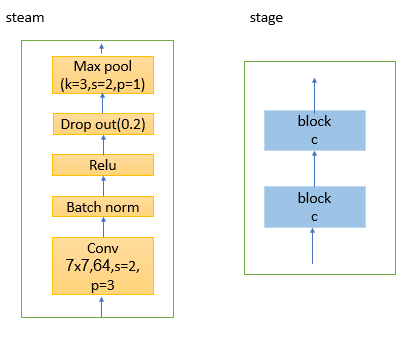

با استفاده از تصاویر مدل ،کلاس زیر را تکمیل کنید.

In [10]:
#To Do
class changer(nn.Module):
  def __init__(self,block,SpatialExchange,ChannelExchange):
    super(changer,self).__init__()

    self.steam=nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

    self.stage1= self._make_stage(64, 64)
    self.stage2= self._make_stage(64, 128)
    self.stage3= self._make_stage(128, 256)
    self.stage4= self._make_stage(256, 512)

    self.spatial_exchange = SpatialExchange()
    self.channel_exchange1 = ChannelExchange()
    self.channel_exchange2 = ChannelExchange()

    self.pool = nn.AdaptiveAvgPool2d((1,1))
    self.flatten = nn.Flatten()
    self.fc = nn.Linear(1024, 3)



  def _make_stage(self, in_channels, c):

    return nn.Sequential(block(in_channels, c),
                         block(c, c))



  def forward(self,x1,x2):
    out1, out2 = self.spatial_exchange((self.stage2(self.stage1(self.steam(x1)))), (self.stage2(self.stage1(self.steam(x2)))))
    out1, out2 = self.channel_exchange1(self.stage3(out1), self.stage3(out2))
    out1, out2 = self.channel_exchange2(self.stage4(out1), self.stage4(out2))
    out = self.pool(torch.cat((out1, out2), dim=1))
    out = self.fc(self.flatten(out))

    return out

In [11]:
## To Do
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

model=changer(block,SpatialExchange,ChannelExchange).to(device)

citeration = nn.BCEWithLogitsLoss()
optimizer= optim.Adam(model.parameters())

cuda


##Train & validation


In [12]:
from tqdm import tqdm
import gc

num_epochs = 5

threshold = 0.4

#training loop
for epoch in tqdm(range(num_epochs)):
    model.train()
    
    train_loss = 0.
    train_acc = 0.
    correct_pred = 0

    for img1, img2, label in iter(train_loader):
        

        img1, img2, label = img1.to(device), img2.to(device), label.to(device)

        logits = model(img1, img2)

        loss = citeration(logits, label)
        train_loss += loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        probs = torch.sigmoid(logits)
        predictions = (probs >= threshold).int()
        correct_pred += (predictions == label).float().prod(dim=1).sum()
        del img1, img2, logits, probs
        if device == 'cuda':
            torch.cuda.empty_cache()
            gc.collect()

    train_acc = correct_pred / len(dataset_train)
    print(f"epoch{epoch}: train loss = {train_loss}, train accuracy = {train_acc}")
    
#validation
val_acc = 0.
val_loss = 0.
correct_pred = 0
model.eval()
for img1, img2, label in iter(val_loader):

    with torch.inference_mode():
        img1, img2, label = img1.to(device), img2.to(device), label.to(device)
        logits = model(img1, img2)
        
        loss = citeration(logits, label)
        val_loss += loss
        
        probs = torch.sigmoid(logits)
        predictions = (probs >= threshold).int()
        correct_pred += (predictions == label).float().prod(dim=1).sum()
        del img1, img2, logits, probs
        if device == 'cuda':
            torch.cuda.empty_cache()
            gc.collect()
val_acc = correct_pred / len(dataset_val)
        
    


print('--------------------------------------------------------')
print(f'loss_TRAIN ={train_loss:.3f},acc_train={train_acc},\t loss_val= {val_loss:.3f}, acc_val={val_acc}')



 20%|██        | 1/5 [16:28<1:05:55, 988.86s/it]

epoch0: train loss = 374.12152099609375, train accuracy = 0.2889658510684967


 40%|████      | 2/5 [32:51<49:14, 984.95s/it]  

epoch1: train loss = 350.5042724609375, train accuracy = 0.3131123185157776


 60%|██████    | 3/5 [49:39<33:10, 995.44s/it]

epoch2: train loss = 344.7552795410156, train accuracy = 0.32647204399108887


 80%|████████  | 4/5 [1:06:31<16:42, 1002.11s/it]

epoch3: train loss = 339.7885437011719, train accuracy = 0.3424047529697418


100%|██████████| 5/5 [1:23:21<00:00, 1000.21s/it]

epoch4: train loss = 330.102783203125, train accuracy = 0.3621474504470825


--------------------------------------------------------
loss_TRAIN =330.103,acc_train=0.3621474504470825,	 loss_val= 34.026, acc_val=0.3735000193119049


In [13]:
BASE_PATH = pathlib.Path("models")
BASE_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "model.pt"
PATH = BASE_PATH / MODEL_NAME

#saving general checkpoints of model
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss},PATH)
    
    

#Test


In [15]:
checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']
model



changer(
  (steam): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (stage1): Sequential(
    (0): block(
      (sub_block1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Dropout(p=0.2, inplace=False)
      )
      (sub_block2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (sub_block3): Sequential(
        (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, 

In [16]:
## To Do test
test_acc = 0.
test_loss = 0.
correct_pred = 0
correct_pred_1 = 0
correct_pred_2 = 0
model.eval()
for img1, img2, label in iter(test_loader):

    with torch.inference_mode():
        img1, img2, label = img1.to(device), img2.to(device), label.to(device)
        logits = model(img1, img2)
        
        loss = citeration(logits, label)
        test_loss += loss
        
        probs = torch.sigmoid(logits)
        predictions = (probs >= threshold).int()
        correct_pred += (predictions == label).float().prod(dim=1).sum()
        for i in range(label.shape[0]):
            if torch.equal(label[i], predictions[i]):

                if torch.sum(label[i]) == 1:
                    correct_pred_1 += 1
                elif torch.sum(label[i]) == 2:
                    correct_pred_2 += 1
        del img1, img2, logits, probs
        if device == 'cuda':
            torch.cuda.empty_cache()
            gc.collect()
test_acc = correct_pred / len(dataset_test)
print(f' loss_test= {test_loss:.3f}, acc_test={(test_acc)}')

 loss_test= 63.365, acc_test=0.27953460812568665


In [17]:
correct_pred_1, correct_pred_2

(39, 559)

سوال تئوری:
بررسی کنید عکس ها با یک ،2 یا 3 تغییر کدام بهتر تشخیص داده میشوند؟

تصاویر با دو تغییر بهتر تشخیص داده شده اند